# eventkit introduction

## Connecting to events and emitting

In [1]:
import eventkit as ev

An event contains a list of callables (the listeners, or handlers) that are
called when the event is emitted. Let'
s make two listeners first:

In [2]:
def f(i):
    print('f got', i)

def g(i):
    print('g got', i)

Now create an event and add the listeners. This is done with the ``connect`` method, or its shorthand ``+=``:

In [3]:
event = ev.Event()
event += f
event += g

When the event emits a value, the value is emitted to all the listeners:

In [4]:
event.emit(42)

f got 42
g got 42


For testing purposes it is often convenient to add the built-in ``print`` function as listener:

In [5]:
event += print

event.emit(43)

f got 43
g got 43
43


Removing a listener is done with ``disconnect``, or ``-=``:

In [6]:
event -= g
event -= print

event.emit(44)

f got 44


All listeners are removed with ``clear``:

In [7]:
event.clear()
event.emit(45)

Nobody's listening...

Multiple arguments can be emitted:

In [8]:
def f(a, b):
    print('f got', a, b)
    
event += f
event.emit(7, 'A')

f got 7 A


Instead of a function let's add a method as listener:

In [9]:
class A:
    
    def on_event(self, s, t):
        print('on_event got', s, t)

        
a = A()
event = ev.Event()
event += a.on_event
event.emit('Whats', 'up?')

on_event got Whats up?


A listener is automatically disconnected when it's garbage collected:

In [10]:
del a
event.emit('Still', 'there?')

Nope, he's gone.

## Time

A crucial aspect of events is their time dimension: Events happen at a certain time. Let's create a timer event to illustrate:

In [11]:
timer = ev.Timer(0.25, count=10)
timer += print

await timer.last();  # to keep output in this cell

0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5


There are multiple other create methods, such as ``Sequence``, ``Repeat``, ``Range`` or ``Timerange``. They are accessible from the ``eventmix`` namespace or as static methods from the ``Event`` class but in lower case.
For example ``ev.Sequence`` is the same as ``Event.sequence``.

Let's try a timerange, it produces absolute datetimes:

In [12]:
event = ev.Timerange(0, 2, 0.25)
event += print

await event.last();  # to keep output in this cell

2019-03-16 11:34:19.250000
2019-03-16 11:34:19.500000
2019-03-16 11:34:19.750000
2019-03-16 11:34:20
2019-03-16 11:34:20.250000
2019-03-16 11:34:20.500000
2019-03-16 11:34:20.750000
2019-03-16 11:34:21


To capture all values produced by an event, the ``list()`` method can be used. It finishes when the event is done and this has to be awaited:

In [13]:
await ev.Range(10).list()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In a plain Python console the same is accomplished with ``event.run()``. The ``run`` method doesn't work in Jupyter, IPython or Eric because they have an already running asyncio event loop.

## Event operators


There are a lot of operations that can be done on events, mostly dealing with selection, transformation, aggregation, combination and timing.

### Selection

The selection operators decide whether an emitted value is passed along or not, but don't change the emitted value. Take for example ``filter``:

In [14]:
event = ev.Range(10).filter(lambda x: x % 2 == 0)

await event.list()

[0, 2, 4, 6, 8]

or ``take``:

In [15]:
event = ev.Sequence('ABCDE').take(3)

await event.list()

['A', 'B', 'C']

Others are ``skip``, ``takeWhile``, ``dropWhile``, ``takeUntil``, ``changes``, ``unique`` and ``last``.

### Transformation

The transformation operators change a source value. For example ``map``, that maps a function onto each source value::

In [16]:
event = ev.Sequence('ABCDE').map(str.lower)

await event.list()

['a', 'b', 'c', 'd', 'e']

or with ``enumerate``:

In [17]:
event = ev.Sequence('ABCDE').enumerate().map(lambda i, c: f'{c}{i}')

await event.list()

['A0', 'B1', 'C2', 'D3', 'E4']

``pluck`` can select nested properties (and also positional arguments):

In [18]:
from pathlib import Path
files = Path('.').glob('*')

event = ev.Sequence(files).pluck('.suffix').unique()

await event.list()

['.ipynb', '.py', '']

There are a multitude of other transformations, including asynchronous mapping and higher-order mapping.

### Aggregation

The aggregation operators aggregate the latest source value into a running result.
Examples are ``Min``, ``Max``, ``Sum``, ``Count`` and ``Mean``. 

Let's try a sum:

In [19]:
event = ev.Range(10).sum()

await event.list()

[0, 1, 3, 6, 10, 15, 21, 28, 36, 45]

Another useful one is ``array``, which emits a numpy array of specified size with the last source values:

In [20]:
event = ev.Range(10).array(3)

await event.list()

[array([0]),
 array([0, 1]),
 array([0, 1, 2]),
 array([1, 2, 3]),
 array([2, 3, 4]),
 array([3, 4, 5]),
 array([4, 5, 6]),
 array([5, 6, 7]),
 array([6, 7, 8]),
 array([7, 8, 9])]

The ``array`` operator has some of the numpy array methods: ``min``, ``max``, ``sum``, ``mean``, ``std``, ``any`` and ``all``. These are specific to arrays and are different from the general operators of the same name.

To sum only over the last 3 periods:

In [21]:
event = ev.Range(10).array(3).sum()

await event.list()

[0, 1, 3, 6, 9, 12, 15, 18, 21, 24]

### Combination

Combining multiple events can be done with ``merge``, ``chain``, ``concat``, ``switch``, ``zip`` or ``ziplatest``.

The first one, ``merge``, passes the emitted values from all source events as soon as they happen:

In [22]:
e1 = ev.Sequence('ABC', 0.01)
e2 = ev.Sequence('123', 0.02)
e3 = ev.Sequence('XYZ', 0.03)

event = e1.merge(e2, e3)

await event.list()

['A', '1', 'X', 'B', 'C', '2', 'Y', '3', 'Z']

``chain`` follows the order of the given sources, queing up emits from next sources:

In [23]:
e1 = ev.Sequence('ABC', 0.01)
e2 = ev.Sequence('123', 0.02)
e3 = ev.Sequence('XYZ', 0.03)

event = e1.chain(e2, e3)

await event.list()

['A', 'B', 'C', '1', '2', '3', 'X', 'Y', 'Z']

``concat`` and ``switch`` only follow one source and drop emits from others. ``concat`` moves to the next in line source that emits and ``switch`` moves to the soonest source to emit.

``zip`` creates matching tuples by queing up emits from all sources and waiting until a full tuple can be emitted:

In [24]:
e1 = ev.Sequence('ABC', 0.01)
e2 = ev.Sequence('123', 0.02)
e3 = ev.Sequence('XYZ', 0.03)

event = e1.zip(e2, e3)

await event.list()

[('A', '1', 'X'), ('B', '2', 'Y'), ('C', '3', 'Z')]

``ziplatest`` doesn't wait, it emits a tuple with the latest value of all sources whenever a source emits.

### Timing

The timing operators deal with emit times. Currently there are ``delay``, ``timeout``, ``sample``, ``throttle`` and ``debounce``.

To delay a source by half a second:

In [25]:
import time
t0 = time.time()

e1 = ev.Range(5, interval=0.1).timestamp().map(lambda t, i: t - t0)
e2 = e1.delay(0.5).timestamp().map(lambda t, i: t - t0)

await e1.zip(e2).list()

[(0.0001652240753173828, 0.5009374618530273),
 (0.10051941871643066, 0.6011934280395508),
 (0.2008514404296875, 0.7014470100402832),
 (0.30123162269592285, 0.8016769886016846),
 (0.4005587100982666, 0.9009032249450684)]

### Tip:

Remember how ``print`` can be used as a listener? This can be done inside a long chain as well:

In [26]:
event = (
    ev.Sequence('abcde')
    .enumerate()
    .map(lambda i, c: (i, i + ord(c)))
    .connect(print)
    .star().pluck(1).map(chr)
)
                                             
await event.list()

(0, 97)
(1, 99)
(2, 101)
(3, 103)
(4, 105)


['a', 'c', 'e', 'g', 'i']

## Piping & forking

A source event can pipe into the next operator in four equivalent ways::
    
    ev.Range(10).take(5)           # familiar 'dot piping'
    ev.Range(10) | ev.Take(5)      # using | pipe symbol
    ev.Range(10).pipe(ev.Take(5))  # using pipe method
    ev.Take(5, ev.Range(10))       # contructor piping

With a fork, the emitted values of an event are fed into multiple operators.
Forking is done with ``fork`` or its shorthand form, square brackets. The forked events
are joined by one the combination methods, such as merge or zip.

The following illustrates this by coursely sampling the min and max of a sine wave:

In [27]:
from math import sin

event = ev.Range(6).map(sin)[ev.Min, ev.Max].zip()

await event.list()

[(0.0, 0.0),
 (0.0, 0.8414709848078965),
 (0.0, 0.9092974268256817),
 (0.0, 0.9092974268256817),
 (-0.7568024953079282, 0.9092974268256817),
 (-0.9589242746631385, 0.9092974268256817)]

Or to create several different delays:

In [28]:
event = ev.Range(5, interval=0.1)[
    ev.Op, ev.Delay(0.1), ev.Delay(0.2), ev.Delay(0.5)].merge()

await event.list()

[0, 0, 1, 0, 1, 2, 1, 2, 3, 4, 2, 3, 0, 4, 3, 1, 4, 2, 3, 4]

Or to get a moving average and standard deviation from a simulated stock price:

In [29]:
import random

sim_stock = ev.Range(500).map(lambda i: random.gauss(0, 1)).sum(100)

bollinger = (
    sim_stock
    .array(50)[ev.ArrayMean, ev.ArrayStd].zip()
    .star().map(lambda av, std: (av, av - 2 * std, av + 2 * std))
    .list()
)
close = sim_stock.list()
await bollinger.last();

# plotting and top-level await don't mix well in one cell, so break into two cells

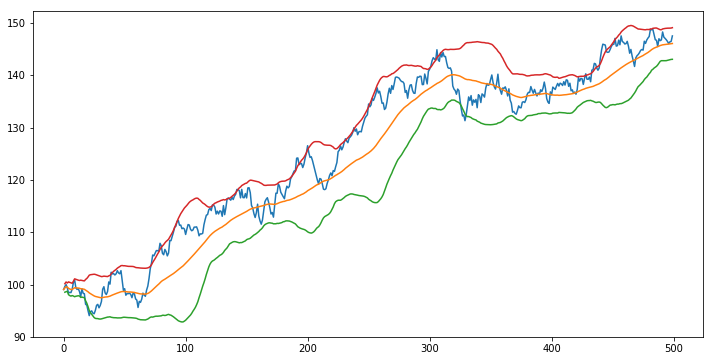

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(close.value());
plt.plot(bollinger.value());

## Flow control

In async pipelines it can be necessary to regulate the speed of the source values so as not to overwhelm the rest of the pipeline.
A way to do this is with a feedback loop, where an emitted result triggers a new source value to be emitted:

In [31]:
import asyncio

async def coro(c):
    await asyncio.sleep(0.2)
    return c.lower()

pacer = ev.Event()
pipe = pacer.iterate('ABCDE').map(coro).connect(pacer.emit)
pacer.emit()  # kickstart pipeline

await pipe.list()

['a', 'b', 'c', 'd', 'e']

The number of kicks detemines the number of tasks in-flight.

## Async interoperability

Two other event constructors that have not been mentioned yet are are ``Wait``, which waits on a Future, and and ``Aiterate`` which creates an Event from an async iterator. The latter one is particularly intereresting: Just like an event, an asynchronous iterator produces values at certain times. The values have to be pulled out of the iterator, which makes it a 'pull' type of method. Events on the other hand are fully 'push' based.

Besides producing a time series of values, async iterators can also throw exceptions and indicate when they have ended. To achieve parity with this, an Event has two additional sub events, called ``error_event`` and ``done_event`` (who have no error or done events themselves to avoid infinite recursion). When an event encounters an error or is done, this is emitted by the corresponding sub event.

With this machinery in place, it is straightforward to go from Event to async iterator:

In [32]:
event = ev.Timerange(0, 2, 0.25)

async for t in event:
    print(t)

2019-03-16 11:34:24.750000
2019-03-16 11:34:25
2019-03-16 11:34:25.250000
2019-03-16 11:34:25.500000
2019-03-16 11:34:25.750000
2019-03-16 11:34:26
2019-03-16 11:34:26.250000
2019-03-16 11:34:26.500000


and back:

In [33]:
async def ait(r):
    for i in r:
        await asyncio.sleep(0.1)
        yield i
    
event = ev.Aiterate(ait('KLMNOP'))

await event.list()

['K', 'L', 'M', 'N', 'O', 'P']

or from Event to Future:

In [34]:
def getFut(result):
    fut = asyncio.Future()
    loop = asyncio.get_event_loop()
    loop.call_later(1, fut.set_result, result)
    return fut

fut = getFut('OK')
event = ev.Wait(fut)

await event.list()

['OK']

or back:

In [35]:
event = ev.Range(3, 10)

await event

3

Notice how awaiting an event produces the first emitted value.

The event operators can also be applied to straight async iterators:

In [36]:
async for t in ev.Merge(ait('XYZ'), ait('KLM'), ait('ABC')).enumerate():
    print(t)

(0, 'X')
(1, 'K')
(2, 'A')
(3, 'Y')
(4, 'L')
(5, 'B')
(6, 'Z')
(7, 'M')
(8, 'C')


or futures:

In [37]:
futs = [getFut(i) for i in range(10)]

await ev.Zip(*futs)

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In the last two examples, where have the events gone? They have been abstracted away, but are still working in the background.

## Final words

While the emphasis of this library is on realtime events, an event can be any sort of data.
The applicability of the library's operators is very general and allows for composing all kinds of data pipelines that can execute both synchronous or asynchronous.

**Bonus riddle:**

In [38]:
async def wave(a, b):
    c = 100
    return a + b / c, b - a / c

start = ev.Event()
pipe = start.map(wave).star().take(1000).connect(start.emit).list()
start.emit(0, 1)

await pipe;

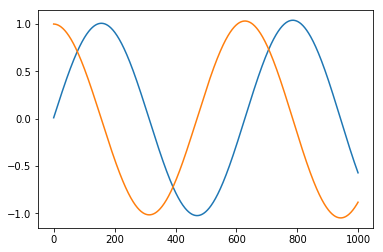

In [39]:
plt.plot(pipe.value());

Now where do these waves come from?